# Day 2 - Lectures on Structural Econometrics for Dynamic Discrete Choice Models 

# 1 - Expectation maximization algorithm. An example

The EM algorithm provides a computationally convenient way to obtain maximum likelihood estimates for "incomplete data" environments. For our purposes, we can think of settings in which each observation in the data is generated by one of two different distribution types. However, the econometrician does not observe which data point has been generated by each type, and only observes the overall distribution. The goal is to identify the distribution of each type and the distribution of the latent variable that governs the distribution over types.

In [105]:
# Load the relevant packages
using StatsKit, ForwardDiff, Ipopt, NLsolve, Optim, Parameters, Zygote, LinearAlgebra, Random, Plots, BenchmarkTools, StatsBase, Distributions

In [106]:
# Uncomment following lines to install one or several packages that are missing

#using Pkg
#Pkg.add(["StatsKit", "ForwardDiff", "Ipopt", "NLsolve", "Optim", "Parameters", "Zygote", "LinearAlgebra", "Random", "Plots", "BenchmarkTools", "StatsBase", "Distributions"])

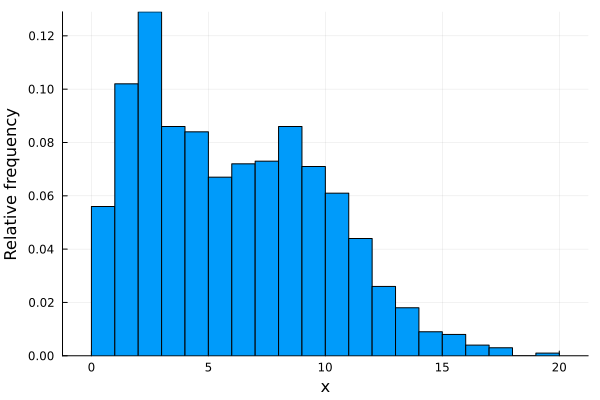

In [107]:
# Generate data
Random.seed!(3000);
nobs=1000;
mix_dist = MixtureModel(Poisson[Poisson(2.0), Poisson(8.0)], [0.4, 0.6]);
Y=rand(mix_dist,nobs);

ex_hist = histogram(Y,normalize=:pdf, bins=0:20,label=nothing,xlabel="x",ylabel = "Relative frequency")

The above figure shows the empirical distribution of 1000 observations of an integer-valued random variable . Suppose we would like to fit a parametric model to this data. The main feature of the data that complicates this exercise is that the data is bimodal with a heavy right tail, and few (if any) standard distributions for discrete random variables will accurately capture this feature. To test, this, let's try fitting a common parametric distribution such as Poisson and see how it does.

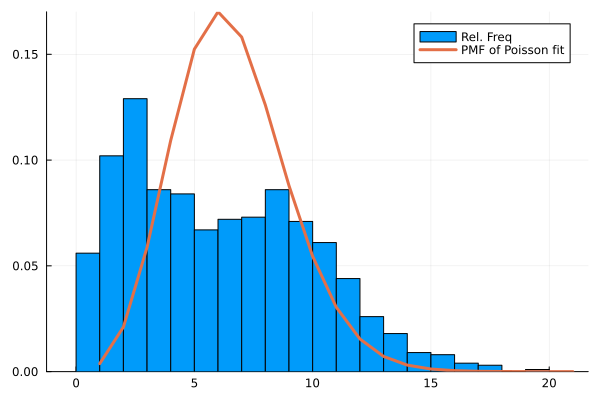

In [108]:
poisson_hat = fit_mle(Poisson, Y);
#geometric_hat = fit_mle(Geometric,Y);

histogram(Y,normalize=:pdf, bins=0:20,label="Rel. Freq")
plot!(pdf.(poisson_hat,0:20),linewidth=3,label = "PMF of Poisson fit")

As we can see from the figure above, the results are not encouraging. Simple parametric models may not suffice to accurately capture the qualitative features of the empirical distribution. While we could consider nonparametric approaches to estimating the distribution, this will have demanding data requirements. We also might have other reasons to believe that the distribution is generated by a finite number of different "types" of random draws that are mixed together in the overall distribution of $Y$.

A common way to estimate these distributions is to consider a mixture model. That is, we will assume that each draw of $Y$ is obtained from distribution $F_1$ with probability $\pi_1$ and distribution $F_2$ with probability $\pi_2 = 1 - \pi_1$. The mixing parameter $\pi_1$ governs the distribution over types, while the distributions $F_1, F_2$ describe the distribution of outcomes within each type. Typically, we will parameterize the distributions with parameters $\theta_1$ and $\theta_2$.

The log-likelihood for observation $y_i$ can be expressed as:

$$\ell_i = \log \big( \pi f_1(y_i; \theta_1) + (1-\pi) f_2(y_i;\theta_2) \big)$$

Practical applications have found that direct maximum likelihood approaches to estimating these parameters perform poorly -- convergence may be slow, there can be many local optima, and the estimates may be extremely sensitive to starting values for the parameters. The alternative approach of Dempster et al (1977) is to update the parameters $\pi$ and $(\theta_1, \theta_2)$ in separate stages. The main features of the estimator can be described in four steps:

- Fix initial values for $\theta_1^{(0)}, \theta_2^{(0)}$, and $\pi^{(0)}$ and set convergence criteria.
- Given the current values for $\theta_1^{(0)}, \theta_2^{(0)}$, compute the probability of each observation type ($P(z_{ij} = 1|\theta_1^{(0)},\theta_2^{(0)})$). This yields an updated value for $\pi_j$.
- Hold fixed the type probabilty computed in step 2 and maximize the likelihood with respect to $\theta_1, \theta_2$. This yields updated values for $\theta_1, \theta_2$.
- Repeat steps 2-3 until convergence (per-iteration change in the overall likelihood is "small").

We will implement this algorithm on the data set above using the assumptions that (i) there are two components in the mixture (i.e., observations are each associated with one of two unobserved types) and (ii) the two types $j \in \{1,2\}$ follow a Poisson distribution with parameter $\theta_j$.

In [109]:
# Step 1 (a): initial values for theta and lambda
theta_0=[1.0,2.0];
pi_0=[0.5,0.5];

# Step 1 (b): specify convergence criteria
iter=1;
maxiter=1000;
lik0=10.0;
normdiff=10.0;
tolerance=1e-6;


### 1 - 1 Expectation step

The expectation step takes the current values of $\theta_1$, $\theta_2$ as fixed and calculates the probability of observation being of type 1 or type 2. We can write the density function of $Y$ conditional on $\theta$, \pi$ , and the (unobserved) $z_{ij}$ as:

$$\prod_{k=1}^2 f(Y_i | \theta_k)^{Z_{ik}}$$

Similarly, the distribution of $z_{ij}$ conditional on $p_j$ is:

$$ \prod_{j=1}^2 \pi_j^{z_{ij}}$$

Bayes theorem implies that the conditional distribution of the $z_{ij}$ are the proportional likelihood of each mixture component $j$ weighted by the current estimates of the mixture weights $\pi_j$

$$E[z_{ij} | Y, {\theta}^{(m)}, \pi^{(m)}] = \frac{\pi^{(m)}_j f(Y_i | \theta^{(m)}_j)}{\pi^{(m)}_1 f(Y_i | \theta^{(m)}_1) + \pi^{(m)}_2 f(Y_i | \theta^{(m)}_2)}$$

In [110]:
EZ = [(pi_0[j]*pdf(Poisson(theta_0[j]),Y[i]))/(sum(pi_0[k]*pdf(Poisson(theta_0[k]),Y[i]) for k∈eachindex(pi_0))) for i ∈ eachindex(Y), j ∈ eachindex(pi_0)];
EZ[1:5,:] # Showing how EZ (matrix NxJ looks, first 5 rows displayed here)

5×2 Matrix{Float64}:
 0.00528111  0.994719
 0.00132553  0.998674
 0.253612    0.746388
 0.0105067   0.989493
 0.00264754  0.997352

### 1 - 2 Maximization step

The maximization step performs a standard maximum likelihood procedure in which the probabilities of being in each group $E[z_{ij}]$ are treated as known and fixed.

$$\mathcal{L} = \sum_{i=1}^N \sum_{j=1}^2 E[z_{ij} | Y, \theta^{(m)}, \pi^{(m)}] \log(f(Y_i | \theta^{(m)}_j) + \sum_{i=1}^N \sum_{j=1}^2 E[z_{ij} | Y, \theta^{(m)}, \pi^{(m)}] \log(\pi_j)$$

Because the likelihood is additively separable in $\pi$ and $\theta$, the maximization step can be done in two parts.

Updating $\pi$ is simple: maximizing $\sum_{i=1}^N \sum_{j=1}^2 E[z_{jk} | Y, \theta^{(m)}, \pi^{(m)}] \log(\pi_j)$ with respect to $\pi_j$ simply requires taking the average of the probability of being each type

In [111]:
pi_0=mean(EZ,dims=1);

Updating $\theta$ requires to numerically optimize the first part of log-likelihood function:

$$\theta^{(m+1)} = \arg \max_{\theta} \sum_{i=1}^N \sum_{j=1}^2 E[Z_{ij} | Y, \theta^{(m)}, \pi^{(m)}] \log(f(Y_i | \theta_j))$$

The last step in each iteration is to calculate the overall likelihood $\mathcal{L}^{(m+1)}$  and check for convergence. If $|\mathcal{L}^{(m+1)}  - \mathcal{L}^{(m)}|$ is less than the convergence criteria, we stop. Otherwise, we proceed to the next iteration.

### 1 - 3 Putting everything in a loop

In [112]:
# Resetting the initial values for optimization

# Step 1 (a): initial values for theta and lambda
theta_0=[1.0,2.0];
pi_0=[0.5,0.5];

# Step 1 (b): specify convergence criteria
iter=1;
maxiter=1000;
lik0=10.0;
normdiff=10.0;
tolerance=1e-6;

# Putting everything in a loop

while normdiff>tolerance && iter<=maxiter
        EZ = [(pi_0[j]*pdf(Poisson(theta_0[j]),Y[i]))/(sum(pi_0[k]*pdf(Poisson(theta_0[k]),Y[i]) for k∈eachindex(pi_0))) for i ∈ eachindex(Y), j ∈ eachindex(pi_0)];
        pi_0=mean(EZ,dims=1);
        theta_fun(theta_0) = -sum(EZ[i,j]*log(pdf(Poisson(theta_0[j]),Y[i])) for i ∈ eachindex(Y), j ∈ eachindex(pi_0));
        b=optimize(theta_fun,theta_0);
        # Calculate likelihood and update for next iteration:
        theta_0=b.minimizer;
        lik1 = -theta_fun(theta_0) + sum(log(pi_0[j])*EZ[i,j] for i∈eachindex(Y), j∈eachindex(pi_0));
        normdiff=abs(lik1-lik0);
        lik0=lik1;
        iter=iter+1;
    end

println(string("π_1, π_2 estimated to:",round.(pi_0,digits=3)))
println(string("θ_1, θ_2 estimated to:",round.(theta_0,digits=3)))


π_1, π_2 estimated to:[0.432 0.568]
θ_1, θ_2 estimated to:[2.138, 8.198]


In [113]:
# Maximizing the whole likelihood at once

using OptimizationOptimJL 
#using Pkg
#Pkg.add("OptimizationOptimJL")

whole_lik(params,data) = -sum(log.(params[3].*pdf.(Poisson(params[1]),data) + (1-params[3]).*pdf.(Poisson(params[2]),data)));

p0 =  [1,2,0.5]

optf = OptimizationFunction(whole_lik, Optimization.AutoForwardDiff())
prob = OptimizationProblem(optf,p0,Y, lb = [0,0,0], ub = [Inf,Inf,1])
sol = solve(prob, NelderMead());

println(string("θ_1, θ_2, π_1 estimated to:",round.(sol.u,digits=3)))


θ_1, θ_2, π_1 estimated to:[2.138, 8.198, 0.432]


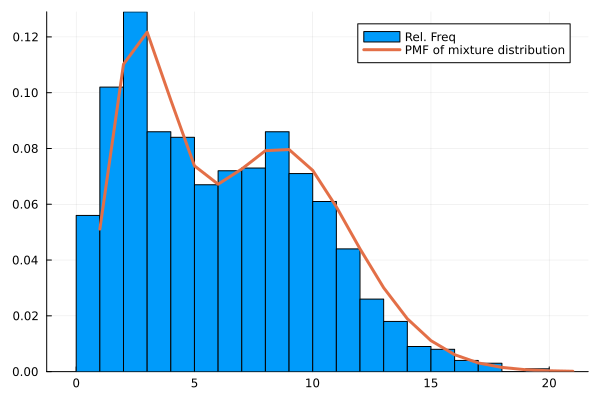

In [114]:
histogram(Y,normalize=:pdf, bins=0:20,label="Rel. Freq")
plot!(pdf.(Poisson(theta_0[1]),0:20)*pi_0[1] .+ pdf.(Poisson(theta_0[2]),0:20)*pi_0[2],linewidth=3,label = "PMF of mixture distribution")

# 2 - Bus engine model with unobserved types (s)

Now we apply the EM algorithm to a dynamic discrete choice model. The basic features of the algorithm do not change: at each iteration, we compute the probability of each individual (or bus) of being of type $s$ given the most recent estimates for $\mathbf{\theta}$, and then use these probabilities to obtain a new estimate for $\mathbf{\theta}$.

The data we will be using is similar to yesterday's data. Two main changes:
- $s$ is not observed by the econometrician in the estimation below.
- We reduce the $X$ state space to 21 values.

To recall the flow utility of not replacing the engine.

$$u_{2t}  =   \theta_1 + \theta_2 x_t + \theta_3 s$$

In [115]:
# Data generation (similar to yesterday's)

function value_function_iteration(X::AbstractRange{Float64},S::Vector{Int64},F1::Matrix{Float64},F2::Matrix{Float64},β::Number,θ::Vector;MaxIter=1000)
    x_len=length(X);
    γ=0.5772;
    value_function2=zeros(x_len,length(S));
    value_diff=1.0;
    tol=1e-5;
    iter=1;
    local v1, v2
    while (value_diff>tol) && (iter<=MaxIter)
        value_function1=value_function2;
        v1=[0.0 + β*F1[j,:]'*value_function1[:,s] for j∈eachindex(X), s∈eachindex(S)];
        v2=[θ[1]+θ[2]*X[j]+θ[3]*S[s] + β*(F2[j,:]'*value_function1[:,s]) for j=1:x_len, s∈eachindex(S)];
        value_function2=[log(exp(v1[j,s])+exp(v2[j,s]))+γ for j=1:x_len, s=1:length(S)];
        iter=iter+1;
        #value_diff=sum((value_function1 .- value_function2).^2);
        value_diff=maximum((value_function1 .- value_function2).^2);
    end
    ccps=[1/(1+exp(v2[j,s,]-v1[j,s])) for j=1:x_len, s=1:length(S)];
    return (ccps_true=ccps, value_function=value_function2)
end

function generate_data(N,T,X,S,F1,F2,F_cumul,β,θ;T_init=10,π=0.4,ex_initial=0)
    if ex_initial==1
        T_init=0;
    end
    x_data=zeros(N,T+T_init);
    x_data_index=Array{Int32}(ones(N,T+T_init));
    if ex_initial==1
        x_data_index[:,1]=rand(1:length(X),N,1);
        x_data[:,1]=X[x_data_index[:,1]];
    end
    s_data=(rand(N) .> π) .+ 1;
    d_data=zeros(N,T+T_init);

    draw_ccp=rand(N,T+T_init);
    draw_x=rand(N,T+T_init);

    (ccps,_)=value_function_iteration(X,S,F1,F2,β,θ);

    for n=1:N
        for t=1:T+T_init
            d_data[n,t]=(draw_ccp[n,t] > ccps[x_data_index[n,t],s_data[n]])+1;
            if t<T+T_init
                x_data_index[n,t+1]=1 + (d_data[n,t]==2)*sum(draw_x[n,t] .> F_cumul[x_data_index[n,t],:]); 
                x_data[n,t+1]=X[x_data_index[n,t+1]];
            end
        end
    end

    return (XData=x_data[:,T_init+1:T+T_init], SData=repeat(s_data,1,T),
        DData=d_data[:,T_init+1:T+T_init],
        XIndexData=x_data_index[:,T_init+1:T_init+T],
        TData=repeat(1:T,N,1),
        NData=repeat((1:N)',1,T)) 
end

x_min=0.0;
x_max=10.0;
x_int=0.5;
x_len=Int32(1+(x_max-x_min)/x_int);
x=range(x_min,x_max,x_len);

# Transition matrix for mileage:
x_tran       = zeros((x_len, x_len));
x_tran_cumul = zeros((x_len, x_len));
x_tday      = repeat(x, 1, x_len); 
x_next      = x_tday';
x_zero      = zeros((x_len, x_len));

x_tran = (x_next.>=x_tday) .* exp.(-(x_next - x_tday)) .* (1 .- exp(-x_int));
x_tran[:,end]=1 .-sum(x_tran[:,1:(end-1)],dims=2);
x_tran_cumul=cumsum(x_tran,dims=2);

S=[1, 2];
s_len=Int32(length(S));
F1=zeros(x_len,x_len);
F1[:,1].=1.0;
F2=x_tran;

N=1000;
T=40;
X=x;
θ=[2.0, -0.15, 1.0];
β=0.9;
F_cumul=x_tran_cumul;
Random.seed!(3000);
XData, SData, DData, XIndexData, TData, NData = generate_data(N,T,X,S,F1,F2,F_cumul,β,θ; ex_initial=1);
γ=Base.MathConstants.eulergamma;


### Estimation

We begin by setting initial values for the parameters $\mathbf{\theta} = \{\theta_1,\theta_2,\theta_3\}$ and $\pi = \{\pi_1,\pi_2\}$. Since $\pi_1 + \pi_2$ in the code we only have to keep track of one of the two parameters (WYLOG, we will refer as $\pi$ to the first). We also define a vector $q$ that accounts for the bus-specific likelihood of being of type $s$ (EZ in the previous exercise). The initial value for $q_{ns}$ is $\pi_s$.

In [116]:
pi_0=0.5;
theta_0=[0.1,0.1,0.1];
q=[pi_0*ones(N,1) (1-pi_0)*ones(N,1)];

As before, the first step is to compute the CCPs, conditional on $x_{nt}$ and $s_n$. Now since $s_n$ is unknown, we weight each observation by the likelihood that it is of type $s$, $q_{ns}$.

$$p^{(0)}_1(x,s) = \frac{\sum_{n=1}^N \sum_{t=1}^T d_{1nt} q^{(0)}_{ns} 1\{x_{nt}=x\}}{\sum_{n=1}^N \sum_{t=1}^T q^{(0)}_{ns} 1\{x_{nt}=x\}}$$

In [117]:
ccp_hat = [sum(repeat(q[:,s],T,1).*(vec(XIndexData) .== j).* (vec(DData) .== 1.0))/sum(repeat(q[:,s],T,1).*(vec(XIndexData) .== j)) for j∈eachindex(X), s∈eachindex(S)];


The convergence parameter is a tolerance level of 1e-7, and we check for convergence by testing the percentage change in the likelihood for values 25 iterations apart. Finally, we set the maximum number of iterations to 1000 and include a check (and error message) in case we reach this level before converging.

In [118]:
iter=1;
cond=0;
max_iter=1000;
tol=1e-6;
lik0=1.0;
stored_lik_vals=zeros(max_iter,1);

### Expectation step

Using the initial values for the parameters established, we first need to calculate the likelihood for each observation bus $n$, time period $t$, and bus type $s$. 

Recall that in the finite Poisson mixture in the example above, we updated the guesses for the probability that observation was type $j$ by using the - $\pi$ weighted likelihoods of observing outcome $Y_i$ conditional on being type $j$ and having type-specific parameters $\theta_j$.

With the dynamic bus engine replacement problem, we proceed similarly. However, we have to remember that the relevant likelihood for establishing whether bus $n$ is of type $s$ is the sequence of replacement decisions $\{d_{nt}\}_{t=1}^T$ made for that bus. Therefore, we calculate the individual likelihood components $\ell_{nt}$ for each bus, period, and type, and then we take the product across time periods $t$ to compute the overall likelihood associated with each bus type $s$.

Each individual likelihood term can be calculated as:

$$ \ell_{nt}(d_{nt} | x_{nt}, s, p_1, \theta) = \frac{d_{1nt} + d_{2nt} \exp(v_2(x_{nt},s) - v_1(x_{nt},s))}{1+\exp(v_2(x_{nt},s) - v_1(x_{nt},s))}$$

where we exploit the one-period finite dependence property inherent to the renewal of the bus engine to express the differences conditional value functions in terms of the one-period ahead conditional choice probabilities:

$$ v_2(x_{nt},s) - v_1(x_{nt},s) = \theta_1 + \theta_2 x_{nt} + \theta_3 s + \beta [ \log(p_1(0, s)) - \sum_{x' \in \mathcal{X}}\log(p_1(x',s)) f_2(x' | x_{nt})]$$


In [119]:
v1_ccp=repeat(β*(-log.(ccp_hat[1,:]') .+ γ),x_len,1);
v2_ccp=[theta_0[1]+theta_0[2]*X[j] + theta_0[3]*S[s] + β*(F2[j,:]'*(-log.(ccp_hat[:,s])) +γ) for j∈eachindex(X), s∈eachindex(S)];

From this, the likelihood for a bus of type $s \in \{1,2\}$ is stored in two separate vectors for each bus $n$ at each point in time $t$.

In [120]:

like_pointwise_1= [((DData[n,t]==2.0)*exp(v2_ccp[XIndexData[n,t],1]-v1_ccp[XIndexData[n,t],1]) +(1-(DData[n,t]==2.0)))/(1+exp(v2_ccp[XIndexData[n,t],1]-v1_ccp[XIndexData[n,t],1])) for n=1:N, t=1:T];
like_pointwise_2= [((DData[n,t]==2.0)*exp(v2_ccp[XIndexData[n,t],2]-v1_ccp[XIndexData[n,t],2]) +(1-(DData[n,t]==2.0)))/(1+exp(v2_ccp[XIndexData[n,t],2]-v1_ccp[XIndexData[n,t],2])) for n=1:N, t=1:T];

And then, we take product for each bus $n$ across time, obtaining the likelihood contribution of each bus, conditional on being type $s$.

In [121]:
ll_pw1=prod(like_pointwise_1,dims=2);
ll_pw2=prod(like_pointwise_2,dims=2);

$q_ns$ is now updated to store the relative likelihood of bus $n$ of being type $s$, weighted by the overall probability $\pi_s$.

$$q^{(m+1)}_{ns} = \frac{\pi^{(m)}_s \prod_{t=1}^T \ell_{nt}(d_{nt} | x_{nt}, s, p_1^{(m)}, \theta^{(m)})}{\sum_{s'=1}^S \pi^{(m)}_{s'} \prod_{t=1}^T \ell_{nt}(d_{nt} | x_{nt}, s', p_1^{(m)}, \theta^{(m)})}$$

And in turn, the average of $q_{ns}$ across $n$ is used to update $\pi_s^{m+1}$.

$$\pi_s^{(m+1)} = (1/N)\sum_{n=1}^N q_{ns}^{(m+1)}$$

In [122]:
q[:,1] .= (pi_0.*ll_pw1)./(pi_0.*ll_pw1 .+ (1-pi_0).*ll_pw2);
q[:,2] .= 1.0 .- q[:,1];
pi_0=mean(q[:,1]);

### Maximization step

Having established the expectation that each bus $n$ is of type $s$ in the previous step, we now perform that maximization step of the algorithm. To update the utility parameters $\theta$, we first need to update the conditional choice probabilities since we are using CCP methods to calculate the likelihood terms.

$$p^{(m+1)}_1(x,s) = \frac{\sum_{n=1}^N \sum_{t=1}^T d_{1nt} q^{(m+1)}_{ns} 1\{x_{nt}=x\}}{\sum_{n=1}^N \sum_{t=1}^T q^{(m+1)}_{ns} 1\{x_{nt}=x\}}$$

In [123]:
ccp_hat = [sum(repeat(q[:,s],T,1).*(vec(XIndexData) .== j).* (vec(DData) .== 1.0))/sum(repeat(q[:,s],T,1).*(vec(XIndexData) .== j)) for j∈eachindex(X), s∈eachindex(S)];

The last maximization step is to update the utility parameters $\theta$. Here we maximize the likelihood, again weighting each likelihood component $\ell_{nt}(d_{nt} | x_{nt}, s_n, p_1^{(m+1)}, \theta)$ by the probability that bus $n$ is of type $s$ using the estimates $q_{ns}$  obtained in the previous step:

$$\theta^{(m+1)} = \arg \max_{\theta} \sum_{n=1}^N \sum_{s=1}^S \sum_{t=1}^T q_{ns}^{(m+1)} \log\big(\ell_{nt}(d_{nt} | x_{nt}, s_n, p_1^{(m+1)}, \theta) \big)$$


In [124]:
# Define the inner likelihood, to be optimized to obtain estimates for theta

function ccp_likelihood_inner(θ,N,T,X,S,F2,XIndexData,DData,q,ccp_hat,β)
    γ=Base.MathConstants.eulergamma;
    x_len=length(X);
    v1_ccp=repeat(β*(-log.(ccp_hat[1,:]') .+ γ),x_len,1);
    v2_ccp=[θ[1]+θ[2]*X[j] + θ[3]*S[s] + β*(F2[j,:]'*(-log.(ccp_hat[:,s])) +γ) for j∈eachindex(X), s∈eachindex(S)];
    q_use=repeat(q[:,1],1,T);
    ccp_lik_1=-sum(q_use[n,t]*((DData[n,t]==2.0)*(v2_ccp[XIndexData[n,t],1]-v1_ccp[XIndexData[n,t],1]) - log(1+exp(v2_ccp[XIndexData[n,t],1]-v1_ccp[XIndexData[n,t],1]))) for n=1:N, t=1:T);
    ccp_lik_2=-sum((1-q_use[n,t])*((DData[n,t]==2.0)*(v2_ccp[XIndexData[n,t],2]-v1_ccp[XIndexData[n,t],2]) - log(1+exp(v2_ccp[XIndexData[n,t],2]-v1_ccp[XIndexData[n,t],2]))) for n=1:N, t=1:T);
    return ccp_lik_1 + ccp_lik_2
end

# Optmize likelihood with respect to theta
inner_lik(θ) = ccp_likelihood_inner(θ,N,T,X,S,F2,XIndexData,DData,q,ccp_hat,β);
optim_res = optimize(inner_lik,theta_0,LBFGS(); autodiff = :forward);
theta_0=optim_res.minimizer;



Now, putting everything together in a while loop until convergence is achieved gives the estimates.

In [125]:
function ccp_likelihood_inner(θ,N,T,X,S,F2,XIndexData,DData,q,ccp_hat,β)
    γ=Base.MathConstants.eulergamma;
    x_len=length(X);
    v1_ccp=repeat(β*(-log.(ccp_hat[1,:]') .+ γ),x_len,1);
    v2_ccp=[θ[1]+θ[2]*X[j] + θ[3]*S[s] + β*(F2[j,:]'*(-log.(ccp_hat[:,s])) +γ) for j∈eachindex(X), s∈eachindex(S)];
    q_use=repeat(q[:,1],1,T);
    ccp_lik_1=-sum(q_use[n,t]*((DData[n,t]==2.0)*(v2_ccp[XIndexData[n,t],1]-v1_ccp[XIndexData[n,t],1]) - log(1+exp(v2_ccp[XIndexData[n,t],1]-v1_ccp[XIndexData[n,t],1]))) for n=1:N, t=1:T);
    ccp_lik_2=-sum((1-q_use[n,t])*((DData[n,t]==2.0)*(v2_ccp[XIndexData[n,t],2]-v1_ccp[XIndexData[n,t],2]) - log(1+exp(v2_ccp[XIndexData[n,t],2]-v1_ccp[XIndexData[n,t],2]))) for n=1:N, t=1:T);
    return ccp_lik_1 + ccp_lik_2
end

while cond==0 && iter<=max_iter
    v1_ccp=repeat(β*(-log.(ccp_hat[1,:]') .+ γ),x_len,1);
    v2_ccp=[theta_0[1]+theta_0[2]*X[j] + theta_0[3]*S[s] + β*(F2[j,:]'*(-log.(ccp_hat[:,s])) +γ) for j∈eachindex(X), s∈eachindex(S)];
    
    # Pointwise likelihood:

    like_pointwise_1= [((DData[n,t]==2.0)*exp(v2_ccp[XIndexData[n,t],1]-v1_ccp[XIndexData[n,t],1]) +(1-(DData[n,t]==2.0)))/(1+exp(v2_ccp[XIndexData[n,t],1]-v1_ccp[XIndexData[n,t],1])) for n=1:N, t=1:T];
    like_pointwise_2= [((DData[n,t]==2.0)*exp(v2_ccp[XIndexData[n,t],2]-v1_ccp[XIndexData[n,t],2]) +(1-(DData[n,t]==2.0)))/(1+exp(v2_ccp[XIndexData[n,t],2]-v1_ccp[XIndexData[n,t],2])) for n=1:N, t=1:T];
    ll_pw1=prod(like_pointwise_1,dims=2);
    ll_pw2=prod(like_pointwise_2,dims=2);

    q[:,1] .= (pi_0.*ll_pw1)./(pi_0.*ll_pw1 .+ (1-pi_0).*ll_pw2);
    q[:,2] .= 1.0 .- q[:,1];
    pi_0=mean(q[:,1]);
    # Maximization
    ccp_hat = [sum(repeat(q[:,s],T,1).*(vec(XIndexData) .== j).* (vec(DData) .== 1.0))/sum(repeat(q[:,s],T,1).*(vec(XIndexData) .== j)) for j∈eachindex(X), s∈eachindex(S)];    inner_lik(θ) = ccp_likelihood_inner(θ,N,T,X,S,F2,XIndexData,DData,q,ccp_hat,β);
    inner_lik(θ) = ccp_likelihood_inner(θ,N,T,X,S,F2,XIndexData,DData,q,ccp_hat,β);
    optim_res = optimize(inner_lik,theta_0,LBFGS(); autodiff = :forward);
    theta_0=optim_res.minimizer;

    stored_lik_vals[iter]=sum(q[:,1].*log.(ll_pw1) + q[:,2].*log.(ll_pw2)) + sum(log(pi_0)*q[:,1] + log(1-pi_0)*q[:,2]);
    if iter>25 
        lik_diff=abs((stored_lik_vals[iter]-stored_lik_vals[iter-25])/stored_lik_vals[iter-25]);
        if lik_diff<tol
            cond=1;
        end
    end
    iter=iter+1;
    if iter>max_iter
        print("Maximum number of iterations reached")
        break
    end
end

println(string("θ_1, θ_2, θ_3 estimated to:",round.(theta_0,digits=3)))
println(string("π_1 estimated to:",round.(pi_0,digits=3)))


θ_1, θ_2, θ_3 estimated to:[2.133, -0.15, 0.848]
π_1 estimated to:0.355
